In [1]:
import sys
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from datetime import datetime
import h5py
import scipy.stats as stats

# Set matplotlib style
%matplotlib widget
%load_ext autoreload
%autoreload 2
plt.style.use('../anemotaxis.mplstyle')
import core.data_loader as data_loader
import core.data_processor as data_processor
import viz.plot_data as plot_data
import utils.preprocessing as preprocessing

In [ ]:
def load_analysis_results(filepath):
    """Load analysis results from HDF5 file."""
    results = {}
    
    with h5py.File(filepath, 'r') as f:
        # Load metadata
        metadata = dict(f.attrs)
        results['metadata'] = metadata
        
        # Load each analysis result group
        for group_name in f.keys():
            group = f[group_name]
            result_dict = {}
            
            # Load attributes (scalars)
            for attr_name, attr_value in group.attrs.items():
                result_dict[attr_name] = attr_value
            
            # Load datasets (arrays)
            for dataset_name in group.keys():
                if isinstance(group[dataset_name], h5py.Group):
                    # Handle arrays of arrays (inhomogeneous data)
                    subgroup = group[datb
                                     aset_name]
                    n_arrays = subgroup.attrs.get('n_arrays', len(subgroup.keys()))
                    arrays = []
                    for i in range(n_arrays):
                        if f'array_{i}' in subgroup:
                            arrays.append(subgroup[f'array_{i}'][:])
                        else:
                            arrays.append(None)  # Handle missing arrays
                    result_dict[dataset_name] = arrays
                else:
                    # Regular homogeneous array
                    result_dict[dataset_name] = group[dataset_name][:]
            
            results[group_name] = result_dict
    
    return results



In [36]:
filepath = '/Users/sharbat/Projects/anemotaxis/data/FCF_attP2-40@UAS_TNT_2_0003/p_5gradient2_2s1x600s0s#n#n#n/20240219_143334/analyses/analysis_results_20251001_090540.h5'
results = load_analysis_results(filepath)
results['ni_time_results']

{'n_larvae': np.int64(20),
 'NI_x_arrays': array([[-0.05849684, -0.06732792, -0.04735207, ..., -0.06220799,
         -0.03926558, -0.00742761],
        [-0.06761994, -0.06397334, -0.16418985, ...,         nan,
                 nan,         nan],
        [-0.13071087, -0.18302933, -0.16945971, ...,         nan,
                 nan,         nan],
        ...,
        [        nan,         nan,         nan, ..., -0.61626484,
         -0.60946257, -0.60787801],
        [        nan,         nan,         nan, ..., -0.22045274,
         -0.14602985, -0.04254827],
        [        nan,         nan,         nan, ..., -0.10960746,
         -0.04655683, -0.04185389]], shape=(20, 55)),
 'NI_y_arrays': array([[-0.01560492, -0.13386257, -0.14080405, ..., -0.1036622 ,
          0.02708988,  0.28244113],
        [ 0.0683726 ,  0.15839015,  0.17813731, ...,         nan,
                 nan,         nan],
        [-0.03505615, -0.10830802, -0.0799871 , ...,         nan,
                 nan,         

In [27]:
def combine_analysis_results(result_files, analysis_type):
    """
    Combine multiple analysis results of the same type.
    
    Args:
        result_files: List of HDF5 file paths
        analysis_type: Type of analysis to combine (e.g., 'run_prob_results')
    
    Returns:
        Combined analysis results
    """
    all_hist_arrays = []
    all_metric_arrays = []
    all_bias_values = []  # For head cast bias data
    all_ni_x_values = []  # For NI single x values
    all_ni_y_values = []  # For NI single y values
    all_ni_x_time_series = []  # For NI time series x
    all_ni_y_time_series = []  # For NI time series y
    all_head_cast_data = []  # For individual head cast records
    all_larva_summaries = []  # For larva-level bias summaries
    bin_centers = None
    time_centers = None
    orientation_bins = None
    n_larvae_total = 0
    
    # Special handling for different analysis types
    is_bias_analysis = 'bias_results' in analysis_type
    is_ni_single = analysis_type == 'ni_single_results'
    is_ni_time = analysis_type == 'ni_time_results'
    is_head_cast = 'head_cast' in analysis_type and 'bias' not in analysis_type
    is_cast_events = analysis_type == 'cast_events_data'
    
    for filepath in result_files:
        try:
            results = load_analysis_results(filepath)
            
            if analysis_type not in results:
                continue
                
            data = results[analysis_type]
            n_larvae_total += data.get('n_larvae', 0)
            
            # Get common axes
            if bin_centers is None and 'bin_centers' in data:
                bin_centers = data['bin_centers']
            if time_centers is None and 'time_centers' in data:
                time_centers = data['time_centers']
            if orientation_bins is None and 'orientation_bins' in data:
                orientation_bins = data['orientation_bins']
            
            # Handle different data structures based on analysis type
            if is_bias_analysis:
                # Head cast bias data - collect individual bias values and summaries
                if 'larva_summaries' in data and data['larva_summaries'] is not None:
                    # Filter out None values and extend the list of larva summaries
                    valid_summaries = [s for s in data['larva_summaries'] if s is not None]
                    all_larva_summaries.extend(valid_summaries)
                    
                    # Extract bias values from larva summaries for overall statistics
                    for summary in valid_summaries:
                        if isinstance(summary, dict):  # Additional safety check
                            if 'upstream_bias' in summary and not np.isnan(summary['upstream_bias']):
                                all_bias_values.append(summary['upstream_bias'])
                            if 'downstream_bias' in summary and not np.isnan(summary['downstream_bias']):
                                all_bias_values.append(summary['downstream_bias'])
                
                # Also collect individual head cast data if available
                if 'head_cast_data' in data and data['head_cast_data'] is not None:
                    # Filter out None values
                    valid_head_casts = [h for h in data['head_cast_data'] if h is not None]
                    all_head_cast_data.extend(valid_head_casts)
                            
            elif is_ni_single:
                # NI single values - collect individual NI values per larva
                if 'NI_x_clean' in data and len(data['NI_x_clean']) > 0:
                    all_ni_x_values.extend(data['NI_x_clean'])
                if 'NI_y_clean' in data and len(data['NI_y_clean']) > 0:
                    all_ni_y_values.extend(data['NI_y_clean'])
                    
            elif is_ni_time:
                # NI time series - collect arrays for each larva
                if 'NI_x_arrays' in data and data['NI_x_arrays'] is not None:
                    ni_x_arrays = np.array(data['NI_x_arrays'])
                    if len(ni_x_arrays.shape) == 2:  # Ensure 2D (n_larvae, n_time_bins)
                        all_ni_x_time_series.append(ni_x_arrays)
                        
                if 'NI_y_arrays' in data and data['NI_y_arrays'] is not None:
                    ni_y_arrays = np.array(data['NI_y_arrays'])
                    if len(ni_y_arrays.shape) == 2:  # Ensure 2D (n_larvae, n_time_bins)
                        all_ni_y_time_series.append(ni_y_arrays)
                        
            elif is_head_cast or is_cast_events:
                # Head cast frequency/orientation - standard histogram handling
                if 'hist_arrays' in data and len(data['hist_arrays']) > 0:
                    hist_arrays = np.array(data['hist_arrays'])
                    if len(hist_arrays.shape) == 2:
                        all_hist_arrays.append(hist_arrays)
                        
                if 'metric_arrays' in data and len(data['metric_arrays']) > 0:
                    metric_arrays = np.array(data['metric_arrays'])
                    if len(metric_arrays.shape) == 2:
                        all_metric_arrays.append(metric_arrays)
                        
            else:
                # Standard histogram/metric data (run prob, turn prob, etc.)
                if 'hist_arrays' in data and len(data['hist_arrays']) > 0:
                    hist_arrays = np.array(data['hist_arrays'])
                    if len(hist_arrays.shape) == 2:
                        all_hist_arrays.append(hist_arrays)
                        
                if 'metric_arrays' in data and len(data['metric_arrays']) > 0:
                    metric_arrays = np.array(data['metric_arrays'])
                    if len(metric_arrays.shape) == 2:
                        all_metric_arrays.append(metric_arrays)
                        
        except Exception as e:
            print(f"⚠️  Error processing {filepath} for {analysis_type}: {e}")
            continue
    
    # Combine all arrays based on data type
    combined_result = {}
    
    # Standard histogram data
    if all_hist_arrays:
        combined_hist_arrays = np.concatenate(all_hist_arrays, axis=0)
        combined_result.update({
            'hist_arrays': combined_hist_arrays,
            'mean_hist': np.nanmean(combined_hist_arrays, axis=0),
            'se_hist': stats.sem(combined_hist_arrays, axis=0, nan_policy='omit'),
            'bin_centers': bin_centers,
            'n_larvae': len(combined_hist_arrays)
        })
    
    # Time series metric data
    if all_metric_arrays:
        combined_metric_arrays = np.concatenate(all_metric_arrays, axis=0)
        combined_result.update({
            'metric_arrays': combined_metric_arrays,
            'mean_metric': np.nanmean(combined_metric_arrays, axis=0),
            'se_metric': stats.sem(combined_metric_arrays, axis=0, nan_policy='omit'),
            'time_centers': time_centers,
            'n_larvae': len(combined_metric_arrays)
        })
    
    # Head cast bias analysis - Updated to match new data structure with proper None handling
    if all_larva_summaries:
        # Recalculate combined statistics from all larva summaries with proper None checks
        combined_upstream_biases = []
        combined_downstream_biases = []
        
        for summary in all_larva_summaries:
            if summary is not None and isinstance(summary, dict):
                if 'upstream_bias' in summary and summary['upstream_bias'] is not None and not np.isnan(summary['upstream_bias']):
                    combined_upstream_biases.append(summary['upstream_bias'])
                if 'downstream_bias' in summary and summary['downstream_bias'] is not None and not np.isnan(summary['downstream_bias']):
                    combined_downstream_biases.append(summary['downstream_bias'])
        
        # Calculate totals from individual head cast data if available
        if all_head_cast_data:
            total_upstream = sum(1 for cast in all_head_cast_data 
                               if cast is not None and cast.get('head_cast_direction') == 'upstream')
            total_downstream = sum(1 for cast in all_head_cast_data 
                                 if cast is not None and cast.get('head_cast_direction') == 'downstream')
            total_casts = len([cast for cast in all_head_cast_data if cast is not None])
            overall_upstream_bias = total_upstream / total_casts if total_casts > 0 else np.nan
            overall_downstream_bias = total_downstream / total_casts if total_casts > 0 else np.nan
            
            # Statistical test: binomial test for bias
            from scipy.stats import binomtest
            if total_casts > 0:
                binom_result = binomtest(total_upstream, total_casts, 0.5, alternative='two-sided')
                p_value_binomial = binom_result.pvalue
            else:
                p_value_binomial = np.nan
        else:
            # Calculate from larva summaries if head cast data not available
            total_upstream = sum(summary.get('upstream_count', 0) for summary in all_larva_summaries 
                               if summary is not None and isinstance(summary, dict))
            total_downstream = sum(summary.get('downstream_count', 0) for summary in all_larva_summaries 
                                 if summary is not None and isinstance(summary, dict))
            total_casts = total_upstream + total_downstream
            overall_upstream_bias = total_upstream / total_casts if total_casts > 0 else np.nan
            overall_downstream_bias = total_downstream / total_casts if total_casts > 0 else np.nan
            p_value_binomial = np.nan
        
        # Per-larva statistics
        mean_larva_upstream_bias = np.nanmean(combined_upstream_biases) if combined_upstream_biases else np.nan
        se_larva_upstream_bias = stats.sem(combined_upstream_biases, nan_policy='omit') if combined_upstream_biases else np.nan
        mean_larva_downstream_bias = np.nanmean(combined_downstream_biases) if combined_downstream_biases else np.nan
        se_larva_downstream_bias = stats.sem(combined_downstream_biases, nan_policy='omit') if combined_downstream_biases else np.nan
        
        combined_result.update({
            'larva_summaries': all_larva_summaries,
            'head_cast_data': all_head_cast_data,
            'total_upstream': total_upstream,
            'total_downstream': total_downstream,
            'total_casts': total_casts,
            'overall_upstream_bias': overall_upstream_bias,
            'overall_downstream_bias': overall_downstream_bias,
            'mean_larva_upstream_bias': mean_larva_upstream_bias,
            'se_larva_upstream_bias': se_larva_upstream_bias,
            'mean_larva_downstream_bias': mean_larva_downstream_bias,
            'se_larva_downstream_bias': se_larva_downstream_bias,
            'p_value_binomial': p_value_binomial,
            'n_larvae': len([s for s in all_larva_summaries if s is not None]),
            'analysis_type': analysis_type.split('_')[-1] if '_' in analysis_type else 'all'  # Extract 'first', 'last', or 'all'
        })
    
    # NI single values
    if all_ni_x_values or all_ni_y_values:
        combined_ni_x = np.array(all_ni_x_values) if all_ni_x_values else np.array([])
        combined_ni_y = np.array(all_ni_y_values) if all_ni_y_values else np.array([])
        
        # Remove NaN values
        combined_ni_x = combined_ni_x[~np.isnan(combined_ni_x)] if len(combined_ni_x) > 0 else combined_ni_x
        combined_ni_y = combined_ni_y[~np.isnan(combined_ni_y)] if len(combined_ni_y) > 0 else combined_ni_y
        
        combined_result.update({
            'NI_x_clean': combined_ni_x,
            'NI_y_clean': combined_ni_y,
            'means': {
                'NI_x': np.nanmean(combined_ni_x) if len(combined_ni_x) > 0 else np.nan,
                'NI_y': np.nanmean(combined_ni_y) if len(combined_ni_y) > 0 else np.nan
            },
            'n_larvae': n_larvae_total
        })
        
        # Add significance testing
        def test_significance(values, test_value=0):
            if len(values) < 3:
                return np.nan, "insufficient data"
            t_stat, p_value = stats.ttest_1samp(values, test_value)
            if p_value < 0.001:
                return p_value, "***"
            elif p_value < 0.01:
                return p_value, "**"
            elif p_value < 0.05:
                return p_value, "*"
            else:
                return p_value, "ns"
        
        p_x, sig_x = test_significance(combined_ni_x) if len(combined_ni_x) > 0 else (np.nan, "insufficient data")
        p_y, sig_y = test_significance(combined_ni_y) if len(combined_ni_y) > 0 else (np.nan, "insufficient data")
        
        combined_result.update({
            'p_values': {'NI_x': p_x, 'NI_y': p_y},
            'significances': {'NI_x': sig_x, 'NI_y': sig_y}
        })
    
    # NI time series data
    if all_ni_x_time_series or all_ni_y_time_series:
        if all_ni_x_time_series:
            combined_ni_x_time = np.concatenate(all_ni_x_time_series, axis=0)
            mean_ni_x_time = np.nanmean(combined_ni_x_time, axis=0)
            se_ni_x_time = stats.sem(combined_ni_x_time, axis=0, nan_policy='omit')
        else:
            combined_ni_x_time = np.array([])
            mean_ni_x_time = np.array([])
            se_ni_x_time = np.array([])
            
        if all_ni_y_time_series:
            combined_ni_y_time = np.concatenate(all_ni_y_time_series, axis=0)
            mean_ni_y_time = np.nanmean(combined_ni_y_time, axis=0)
            se_ni_y_time = stats.sem(combined_ni_y_time, axis=0, nan_policy='omit')
        else:
            combined_ni_y_time = np.array([])
            mean_ni_y_time = np.array([])
            se_ni_y_time = np.array([])
        
        combined_result.update({
            'NI_x_arrays': combined_ni_x_time,
            'NI_y_arrays': combined_ni_y_time,
            'mean_NI_x': mean_ni_x_time,
            'mean_NI_y': mean_ni_y_time,
            'se_NI_x': se_ni_x_time,
            'se_NI_y': se_ni_y_time,
            'time_centers': time_centers,
            'n_larvae': n_larvae_total
        })
    
    # Add common elements
    if bin_centers is not None:
        combined_result['bin_centers'] = bin_centers
    if time_centers is not None:
        combined_result['time_centers'] = time_centers
    if orientation_bins is not None:
        combined_result['orientation_bins'] = orientation_bins
    
    # Add total larvae count if not already added
    if 'n_larvae' not in combined_result:
        combined_result['n_larvae'] = n_larvae_total
    
    return combined_result if combined_result else None

In [24]:
def get_latest_analysis_files(experiment_dates, base_path=None):
    """
    Get the latest analysis .h5 files for given experiment dates.
    
    Args:
        experiment_dates: List of experiment dates (e.g., ['20240219_143334', '20240223_112627'])
        base_path: Base path to the data directory (optional)
    
    Returns:
        List of paths to the latest .h5 files for each date
    """
    if base_path is None:
        base_path = '/Users/sharbat/Projects/anemotaxis/data/FCF_attP2-40@UAS_TNT_2_0003/p_5gradient2_2s1x600s0s#n#n#n'
    
    result_files = []
    
    for date in experiment_dates:
        # Construct the analyses directory path
        analyses_dir = os.path.join(base_path, date, 'analyses')
        
        if not os.path.exists(analyses_dir):
            print(f"⚠️  Warning: Directory not found for {date}: {analyses_dir}")
            continue
        
        # Find all .h5 files with analysis_results pattern
        pattern = os.path.join(analyses_dir, 'analysis_results_*.h5')
        h5_files = glob.glob(pattern)
        
        if not h5_files:
            print(f"⚠️  Warning: No .h5 files found for {date}")
            continue
        
        # Sort by filename (timestamp is in filename) and get the latest
        h5_files.sort()
        latest_file = h5_files[-1]
        result_files.append(latest_file)
        
        # Extract timestamp from filename for confirmation
        filename = os.path.basename(latest_file)
        timestamp = filename.replace('analysis_results_', '').replace('.h5', '')
        print(f"✅ {date}: Using latest file with timestamp {timestamp}")
    
    return result_files

In [ ]:
# Just provide your experiment dates here:
experiment_dates = [
    # timothee
    '20240219_143334',
    '20240223_112627', 
    '20240226_145653',
    '20240226_145653',
    '20240226_163646',
    '20240301_105819',
    '20240301_121446',
    '20240304_151714',
    '20240304_162010',
    '20240308_104430',
    '20240308_124423',
    # mine
    '20250711_112928',
    '20250712_115018',
    '20250712_131147',
    '20250715_112915',
    '20250715_112915',
    '20250801_111753',
    '20250804_110703',
    '20250805_103511',
    '20250908_135226',
    '20250908_140738'
]

# Automatically get the latest .h5 files
result_files = get_latest_analysis_files(experiment_dates)

# Verify the files exist
print(f"\n🔍 Verifying files exist:")
for file in result_files:
    exists = "✅" if os.path.exists(file) else "❌"
    print(f"  {exists} {os.path.basename(file)}")

print(result_files)

✅ 20240219_143334: Using latest file with timestamp 20251001_090540
✅ 20240223_112627: Using latest file with timestamp 20251001_090656
✅ 20240226_145653: Using latest file with timestamp 20251001_090743
✅ 20240226_145653: Using latest file with timestamp 20251001_090743
✅ 20240226_163646: Using latest file with timestamp 20251001_090953
✅ 20240301_105819: Using latest file with timestamp 20251001_091043
✅ 20240301_121446: Using latest file with timestamp 20251001_091213
✅ 20240304_151714: Using latest file with timestamp 20251001_091319
✅ 20240304_162010: Using latest file with timestamp 20251001_091414
✅ 20240308_104430: Using latest file with timestamp 20251001_091519
✅ 20240308_124423: Using latest file with timestamp 20251001_091630
✅ 20250711_112928: Using latest file with timestamp 20251001_091753
⚠️  Warning: No .h5 files found for 20250712_115018
✅ 20250712_131147: Using latest file with timestamp 20251001_091900
✅ 20250715_112915: Using latest file with timestamp 20251001_091

In [46]:
output_dir = '/Users/sharbat/Projects/anemotaxis/data/FCF_attP2-40@UAS_TNT_2_0003/p_5gradient2_2s1x600s0s#n#n#n/analyses'
os.makedirs(output_dir, exist_ok=True)

# Combine all analysis results (matching analyze_single_anemotaxis.ipynb)
print("🔄 Combining analysis results...")

# Basic behavioral analyses
combined_run_prob = combine_analysis_results(result_files, 'run_prob_results')
combined_run_prob_time = combine_analysis_results(result_files, 'run_prob_time_results')
combined_turn_prob = combine_analysis_results(result_files, 'turn_prob_results')
combined_turn_prob_time = combine_analysis_results(result_files, 'turn_prob_time_results')
combined_velocity = combine_analysis_results(result_files, 'velocity_results')
combined_velocity_time = combine_analysis_results(result_files, 'velocity_time_results')
combined_turn_amp = combine_analysis_results(result_files, 'turn_amp_results')
combined_turn_amp_time = combine_analysis_results(result_files, 'turn_amp_time_results')
combined_turn_rate = combine_analysis_results(result_files, 'turn_rate_results')
combined_turn_rate_time = combine_analysis_results(result_files, 'turn_rate_time_results')
combined_backup_prob = combine_analysis_results(result_files, 'backup_prob_results')
combined_backup_prob_time = combine_analysis_results(result_files, 'backup_prob_time_results')

# Head cast analyses
combined_cast_events = combine_analysis_results(result_files, 'cast_events_data')
combined_bias_first = combine_analysis_results(result_files, 'bias_results_first')
combined_bias_last = combine_analysis_results(result_files, 'bias_results_last')
combined_bias_all = combine_analysis_results(result_files, 'bias_results_all')
combined_head_cast_orientation = combine_analysis_results(result_files, 'head_cast_orientation_results')
combined_head_cast_time = combine_analysis_results(result_files, 'head_cast_time_results')

# Navigational Index analyses
combined_ni_time = combine_analysis_results(result_files, 'ni_time_results')
combined_ni_single = combine_analysis_results(result_files, 'ni_single_results')

print("✅ All analysis results combined successfully!")
print(f"📊 Total datasets processed: {len(result_files)}")

# Print summary of combined data with detailed status
print("\n📋 Summary of combined analyses:")

# Basic behavioral analyses status
behavioral_analyses = {
    'run_prob': combined_run_prob,
    'run_prob_time': combined_run_prob_time,
    'turn_prob': combined_turn_prob,
    'turn_prob_time': combined_turn_prob_time,
    'velocity': combined_velocity,
    'velocity_time': combined_velocity_time,
    'turn_amp': combined_turn_amp,
    'turn_amp_time': combined_turn_amp_time,
    'backup_prob': combined_backup_prob,
    'backup_prob_time': combined_backup_prob_time
}

for name, result in behavioral_analyses.items():
    status = "✅" if result else "❌"
    n_larvae = result.get('n_larvae', 0) if result else 0
    print(f"  {status} {name}: {n_larvae} larvae")

# Head cast analyses status
head_cast_analyses = {
    'cast_events': combined_cast_events,
    'bias_first': combined_bias_first,
    'bias_last': combined_bias_last,
    'bias_all': combined_bias_all,
    'head_cast_orientation': combined_head_cast_orientation,
    'head_cast_time': combined_head_cast_time
}

print("\n🎯 Head cast analyses:")
for name, result in head_cast_analyses.items():
    status = "✅" if result else "❌"
    if result:
        if 'n_larvae' in result:
            n_larvae = result['n_larvae']
        elif 'n_values' in result:
            n_values = result['n_values']
            print(f"  {status} {name}: {n_values} values")
            continue
        else:
            n_larvae = 0
        print(f"  {status} {name}: {n_larvae} larvae")
    else:
        print(f"  {status} {name}: 0 larvae")

# NI analyses status
ni_analyses = {
    'ni_time': combined_ni_time,
    'ni_single': combined_ni_single
}

print("\n🧭 Navigational Index analyses:")
for name, result in ni_analyses.items():
    status = "✅" if result else "❌"
    if result:
        n_larvae = result.get('n_larvae', 0)
        if 'NI_x_clean' in result:
            n_x_values = len(result['NI_x_clean'])
            n_y_values = len(result['NI_y_clean']) if 'NI_y_clean' in result else 0
            print(f"  {status} {name}: {n_larvae} larvae, {n_x_values} x-values, {n_y_values} y-values")
        else:
            print(f"  {status} {name}: {n_larvae} larvae")
    else:
        print(f"  {status} {name}: 0 larvae")

# Overall summary
if combined_run_prob and 'n_larvae' in combined_run_prob:
    print(f"\n🐛 Total larvae in combined analysis: {combined_run_prob['n_larvae']}")

🔄 Combining analysis results...


/var/folders/qs/_71td1zx7kjd4t5xhw9wndn00000gp/T/ipykernel_89381/2764691612.py:139: RuntimeWarning: Mean of empty slice
  'mean_metric': np.nanmean(combined_metric_arrays, axis=0),
/var/folders/qs/_71td1zx7kjd4t5xhw9wndn00000gp/T/ipykernel_89381/2764691612.py:140: SmallSampleWarning: After omitting NaNs, one or more axis-slices of one or more sample arguments is too small; corresponding elements of returned arrays will be NaN. See documentation for sample size requirements.
  'se_metric': stats.sem(combined_metric_arrays, axis=0, nan_policy='omit'),


✅ All analysis results combined successfully!
📊 Total datasets processed: 20

📋 Summary of combined analyses:
  ✅ run_prob: 391 larvae
  ✅ run_prob_time: 391 larvae
  ✅ turn_prob: 391 larvae
  ✅ turn_prob_time: 391 larvae
  ✅ velocity: 382 larvae
  ✅ velocity_time: 391 larvae
  ✅ turn_amp: 391 larvae
  ✅ turn_amp_time: 391 larvae
  ✅ backup_prob: 391 larvae
  ✅ backup_prob_time: 391 larvae

🎯 Head cast analyses:
  ✅ cast_events: 0 larvae
  ✅ bias_first: 380 larvae
  ✅ bias_last: 380 larvae
  ✅ bias_all: 380 larvae
  ✅ head_cast_orientation: 390 larvae
  ✅ head_cast_time: 390 larvae

🧭 Navigational Index analyses:
  ✅ ni_time: 391 larvae
  ✅ ni_single: 391 larvae, 391 x-values, 391 y-values

🐛 Total larvae in combined analysis: 391


Saved to: /Users/sharbat/Projects/anemotaxis/data/FCF_attP2-40@UAS_TNT_2_0003/p_5gradient2_2s1x600s0s#n#n#n/analyses


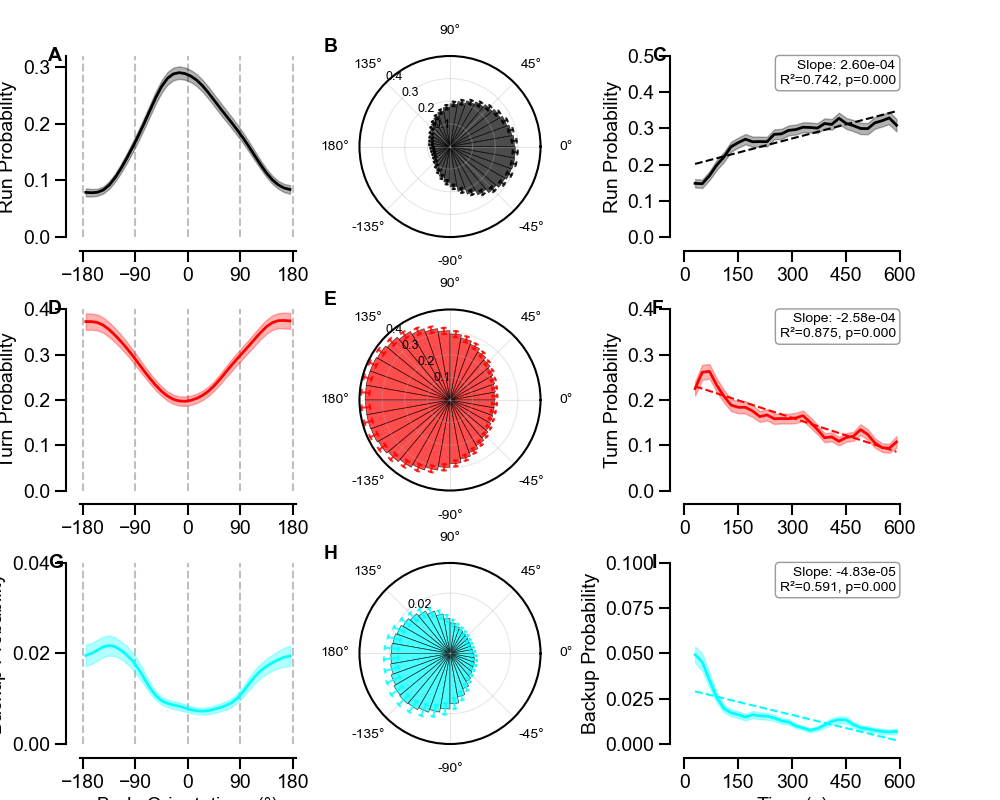

In [ ]:
# Create figure with asymmetric spacing - polar plots closer to left
fig = plt.figure(figsize=(10, 8))
gs = GridSpec(3, 3, figure=fig, 
              left=0.08, right=0.90,
              top=0.93, bottom=0.07,
              wspace=0.4,               # Reduced overall spacing
              hspace=0.4,
              width_ratios=[0.6, 0.6, 0.6])  # Left wide, middle narrow, right wide

# Row 1: Run analysis
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1], projection='polar')
ax7 = fig.add_subplot(gs[0, 2])

plot_data.plot_run_probabilities(combined_run_prob, ax=ax1, ylabel = 'Run Probability', show_xlabel=False)
ax1.text(-0.15, 1.05, 'A', transform=ax1.transAxes, fontsize=14, fontweight='bold', va='top', ha='left')

plot_data.plot_run_probabilities_polar(combined_run_prob, ax=ax2, bar_style=True, tick_fontsize=10)
ax2_pos = ax2.get_position()
ax2.set_position([ax2_pos.x0 - 0.04, ax2_pos.y0, ax2_pos.width, ax2_pos.height])
ax2.text(-0.2, 1.1, 'B', transform=ax2.transAxes, fontsize=14, fontweight='bold', va='top', ha='left')

plot_data.plot_run_probability_over_time(
    combined_run_prob_time, ylim=(0, 0.5), ylabel='Run Probability',
    show_individuals=False, show_error=True, ax=ax7, show_xlabel=False
)
ax7.text(-0.15, 1.05, 'C', transform=ax7.transAxes, fontsize=14, fontweight='bold', va='top', ha='left')

# Row 2: Turn analysis
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1], projection='polar')
ax8 = fig.add_subplot(gs[1, 2])

plot_data.plot_turn_probabilities(combined_turn_prob, ax=ax3, ylim = [0.1,0.4], ylabel = 'Turn Probability', show_xlabel=False)
ax3.text(-0.15, 1.05, 'D', transform=ax3.transAxes, fontsize=14, fontweight='bold', va='top', ha='left')

plot_data.plot_turn_probabilities_polar(combined_turn_prob, ax=ax4, bar_style=True, tick_fontsize=10)
ax4_pos = ax4.get_position()
ax4.set_position([ax4_pos.x0 - 0.04, ax4_pos.y0, ax4_pos.width, ax4_pos.height])
ax4.text(-0.2, 1.1, 'E', transform=ax4.transAxes, fontsize=14, fontweight='bold', va='top', ha='left')

plot_data.plot_turn_probability_over_time(
    combined_turn_prob_time, ylim=(0, 0.4), ylabel='Turn Probability',
    show_individuals=False, show_error=True, ax=ax8, show_xlabel=False
)
ax8.text(-0.15, 1.05, 'F', transform=ax8.transAxes, fontsize=14, fontweight='bold', va='top', ha='left')

# Row 3: Backup analysis
ax5 = fig.add_subplot(gs[2, 0])
ax6 = fig.add_subplot(gs[2, 1], projection='polar')
ax9 = fig.add_subplot(gs[2, 2])

plot_data.plot_backup_probabilities(combined_backup_prob, ax=ax5, ylabel='Backup Probability', show_xlabel=True)
ax5.text(-0.15, 1.05, 'G', transform=ax5.transAxes, fontsize=14, fontweight='bold', va='top', ha='left')

plot_data.plot_backup_probabilities_polar(combined_backup_prob, ax=ax6, bar_style=True, tick_fontsize=10)
ax6_pos = ax6.get_position()
ax6.set_position([ax6_pos.x0 - 0.04, ax6_pos.y0, ax6_pos.width, ax6_pos.height])
ax6.text(-0.2, 1.1, 'H', transform=ax6.transAxes, fontsize=14, fontweight='bold', va='top', ha='left')

plot_data.plot_backup_probability_over_time(
    combined_backup_prob_time, ylabel='Backup Probability', ylim=(0, 0.1),
    show_individuals=False, show_error=True, ax=ax9, show_xlabel=True
)
ax9.text(-0.15, 1.05, 'I', transform=ax9.transAxes, fontsize=14, fontweight='bold', va='top', ha='left')

fig.savefig(os.path.join(output_dir, 'behavioral_analysis_summary.pdf'), 
            bbox_inches='tight', 
            dpi=300,
            transparent=True,      # Transparent background
            facecolor='none')      # No face color

print(f"Saved to: {output_dir}")

Combined velocity & amplitude figure saved to: /Users/sharbat/Projects/anemotaxis/data/FCF_attP2-40@UAS_TNT_2_0003/p_5gradient2_2s1x600s0s#n#n#n/analyses/velocity_amplitude_analysis.pdf


/Users/sharbat/Projects/anemotaxis/src/viz/plot_data.py:1356: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(mean_values + np.array(se_values)) if len(se_values) > 0 else np.nanmax(mean_values)


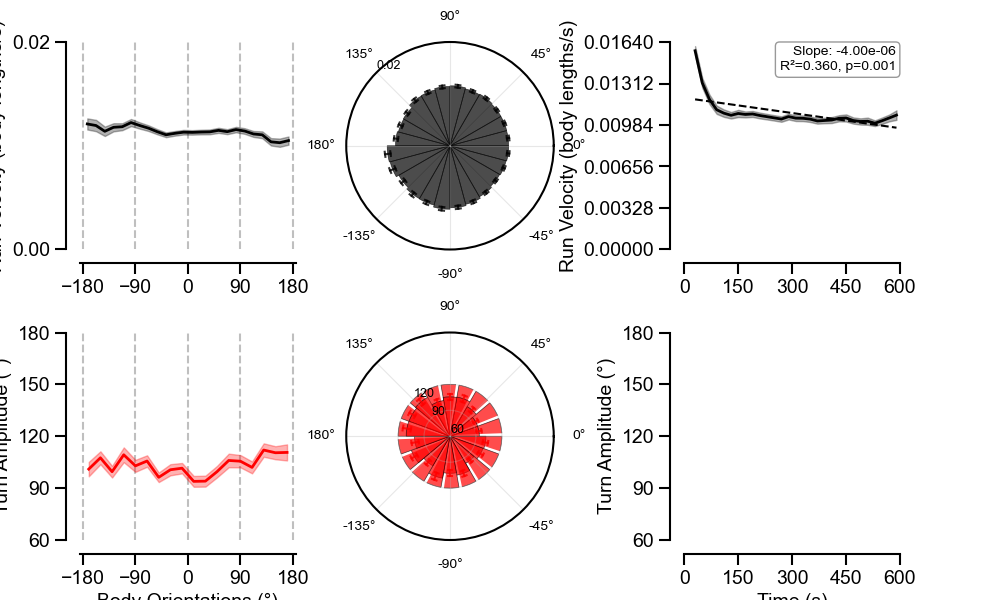

In [ ]:
# Create combined figure with asymmetric spacing - polar plots closer to left
fig_combined = plt.figure(figsize=(10, 6))
gs_combined = GridSpec(2, 3, figure=fig_combined, 
                      left=0.08, right=0.90,
                      top=0.93, bottom=0.10,
                      wspace=0.4,               # Reduced overall spacing
                      hspace=0.4,
                      width_ratios=[0.6, 0.6, 0.6])  # Left wide, middle narrow, right wide

# Row 1: Run Velocity Analysis
ax_vel1 = fig_combined.add_subplot(gs_combined[0, 0])
ax_vel2 = fig_combined.add_subplot(gs_combined[0, 1], projection='polar')
ax_vel3 = fig_combined.add_subplot(gs_combined[0, 2])


# Linear plot
plot_data.plot_run_velocity(combined_velocity, ax=ax_vel1, show_xlabel=False, ylabel='Run Velocity (body lengths/s)')

# Polar plot
plot_data.plot_run_velocity_polar(combined_velocity, ax=ax_vel2, bar_style=True, tick_fontsize=10)
ax_vel2_pos = ax_vel2.get_position()
ax_vel2.set_position([ax_vel2_pos.x0 - 0.04, ax_vel2_pos.y0, ax_vel2_pos.width, ax_vel2_pos.height])

# Time series plot
plot_data.plot_run_velocity_over_time(
    combined_velocity_time, ylabel='Run Velocity (body lengths/s)',
    show_individuals=False, show_error=True, ax=ax_vel3, show_xlabel=False
)

# Row 2: Turn Amplitude Analysis
ax_amp1 = fig_combined.add_subplot(gs_combined[1, 0])
ax_amp2 = fig_combined.add_subplot(gs_combined[1, 1], projection='polar')
ax_amp3 = fig_combined.add_subplot(gs_combined[1, 2])

# Set minimum amplitude
min_amp = 60

# Check if we have ANY valid (non-NaN) data
if combined_turn_amp and 'mean_hist' in combined_turn_amp:
    mean_hist = np.array(combined_turn_amp['mean_hist'])
    has_data = np.any(~np.isnan(mean_hist))
else:
    has_data = False


# Linear plot
plot_data.plot_turn_amplitudes(combined_turn_amp, ax=ax_amp1, ylabel='Turn Amplitude (°)', show_xlabel=True, min_amplitude=min_amp)

# Polar plot - only if there's valid data
plot_data.plot_turn_amplitudes_polar(combined_turn_amp, ax=ax_amp2, bar_style=True, 
                                    tick_fontsize=10, min_amplitude=min_amp)
ax_amp2_pos = ax_amp2.get_position()
ax_amp2.set_position([ax_amp2_pos.x0 - 0.04, ax_amp2_pos.y0, ax_amp2_pos.width, ax_amp2_pos.height])

# Time series plot
plot_data.plot_turn_amplitudes_over_time(
    combined_turn_amp_time, ylabel='Turn Amplitude (°)',
    show_individuals=False, show_error=True, ax=ax_amp3, show_xlabel=True,
    min_amplitude=min_amp
)


# Save the combined figure
fig_combined.savefig(os.path.join(output_dir, 'velocity_amplitude_analysis.pdf'), 
                    bbox_inches='tight', 
                    dpi=300,
                    transparent=True,
                    facecolor='none')
print(f"Combined velocity & amplitude figure saved to: {os.path.join(output_dir, 'velocity_amplitude_analysis.pdf')}")

plt.show()
######### WHY DOES IT HAVE NaN SAVED AND NOTHING ELSE!!!!!!!!! ##########
######### WHY DOES IT HAVE NaN SAVED AND NOTHING ELSE!!!!!!!!! ##########
######### WHY DOES IT HAVE NaN SAVED AND NOTHING ELSE!!!!!!!!! ##########
######### WHY DOES IT HAVE NaN SAVED AND NOTHING ELSE!!!!!!!!! ##########

In [48]:
combined_bias_last
######### WHY DOES IT HAVE NaN SAVED AND NOTHING ELSE!!!!!!!!! ##########
######### WHY DOES IT HAVE NaN SAVED AND NOTHING ELSE!!!!!!!!! ##########
######### WHY DOES IT HAVE NaN SAVED AND NOTHING ELSE!!!!!!!!! ##########
######### WHY DOES IT HAVE NaN SAVED AND NOTHING ELSE!!!!!!!!! ##########


{'n_larvae': np.int64(380)}

Figure saved to /Users/sharbat/Projects/anemotaxis/data/FCF_attP2-40@UAS_TNT_2_0003/p_5gradient2_2s1x600s0s#n#n#n/analyses/ni_over_time.pdf


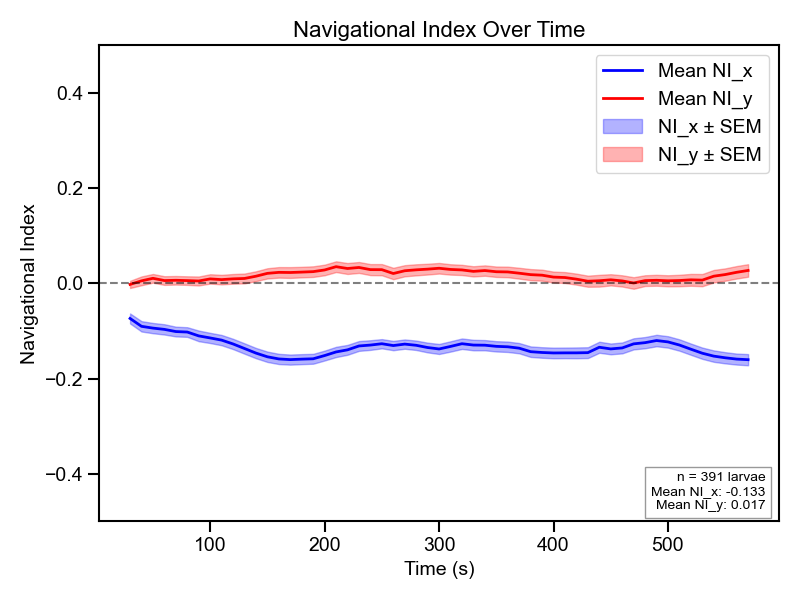

Figure saved to /Users/sharbat/Projects/anemotaxis/data/FCF_attP2-40@UAS_TNT_2_0003/p_5gradient2_2s1x600s0s#n#n#n/analyses/ni_boxplot.pdf


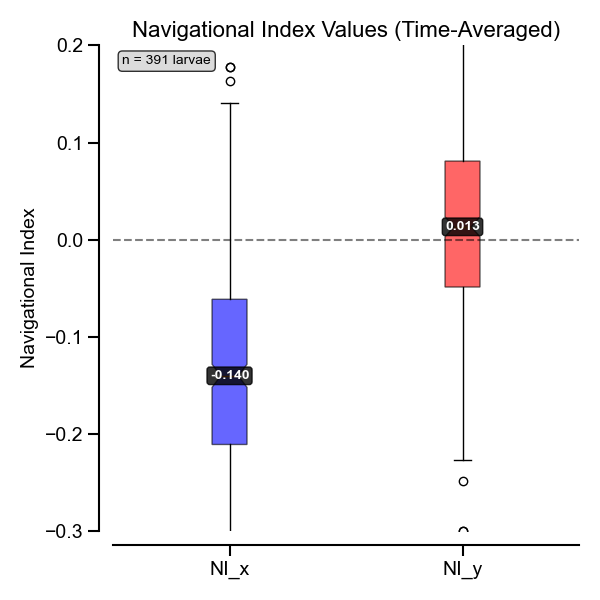

In [41]:
# 3. Plot time series
fig_time = plot_data.plot_navigational_index_over_time(
    combined_ni_time,
    save_path=os.path.join(output_dir, 'ni_over_time.pdf')
)

# 4. Plot box plots
fig_box = plot_data.plot_navigational_index_boxplot(
    combined_ni_single,
    save_path=os.path.join(output_dir, 'ni_boxplot.pdf')
)

Head cast analysis figure saved to: /Users/sharbat/Projects/anemotaxis/data/FCF_attP2-40@UAS_TNT_2_0003/p_5gradient2_2s1x600s0s#n#n#n/analyses/head_cast_analysis.pdf


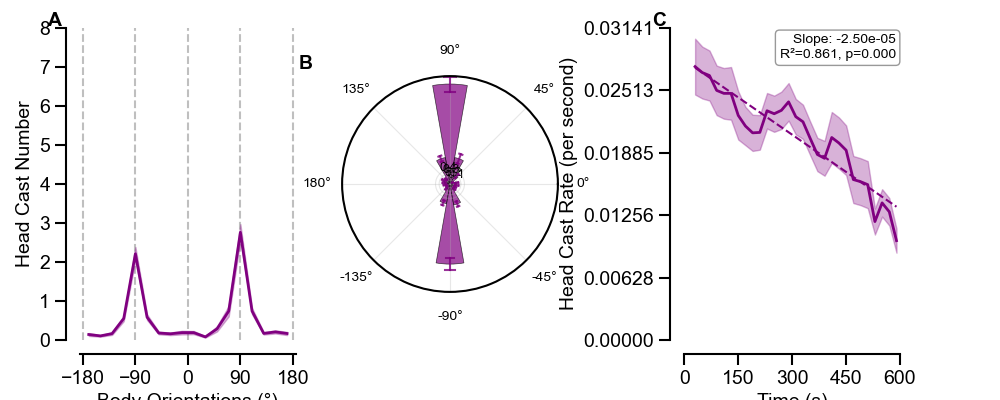

In [43]:
# Create combined figure for head cast analysis - matching the style of other analysis plots
fig_head_casts = plt.figure(figsize=(10, 4))  # Single row, so height is 4
gs_head_casts = GridSpec(1, 3, figure=fig_head_casts, 
                        left=0.08, right=0.90,
                        top=0.93, bottom=0.15,  # More bottom space for single row
                        wspace=0.4,               
                        width_ratios=[0.6, 0.6, 0.6])

# Row 1: Head Cast Analysis
ax_hc1 = fig_head_casts.add_subplot(gs_head_casts[0, 0])
ax_hc2 = fig_head_casts.add_subplot(gs_head_casts[0, 1], projection='polar')
ax_hc3 = fig_head_casts.add_subplot(gs_head_casts[0, 2])

# Linear plot - Head cast frequency by orientation
plot_data.plot_head_cast_frequency(combined_head_cast_orientation,
                                   ylim=[0, 8], 
                                   ax=ax_hc1, 
                                   show_xlabel=True, 
                                   ylabel='Head Cast Number')
ax_hc1.text(-0.15, 1.05, 'A', transform=ax_hc1.transAxes, 
            fontsize=14, fontweight='bold', va='top', ha='left')

# Polar plot - Head cast frequency by orientation
plot_data.plot_head_cast_frequency_polar(combined_head_cast_orientation, 
                                         ax=ax_hc2, 
                                         bar_style=True, 
                                         tick_fontsize=10)
ax_hc2_pos = ax_hc2.get_position()
ax_hc2.set_position([ax_hc2_pos.x0 - 0.04, ax_hc2_pos.y0, ax_hc2_pos.width, ax_hc2_pos.height])
ax_hc2.text(-0.2, 1.1, 'B', transform=ax_hc2.transAxes, 
            fontsize=14, fontweight='bold', va='top', ha='left')

# Time series plot - Head cast frequency over time
plot_data.plot_head_cast_frequency_over_time(
    combined_head_cast_time,
    ylabel='Head Cast Rate (per second)',
    show_individuals=False, 
    show_error=True, 
    ax=ax_hc3, 
    show_xlabel=True
)
ax_hc3.text(-0.15, 1.05, 'C', transform=ax_hc3.transAxes, 
            fontsize=14, fontweight='bold', va='top', ha='left')

# Save the head cast analysis figure
fig_head_casts.savefig(os.path.join(output_dir, 'head_cast_analysis.pdf'), 
                      bbox_inches='tight', 
                      dpi=300,
                      transparent=True,
                      facecolor='none')
print(f"Head cast analysis figure saved to: {os.path.join(output_dir, 'head_cast_analysis.pdf')}")

# # Save metadata for the head cast analysis figure
# head_cast_metadata = save_figure_metadata(
#     output_dir,
#     'head_cast_analysis',
#     result_files,
#     additional_info={
#         'analysis_types': ['head_cast_orientation', 'head_cast_time_series'],
#         'plot_types': ['linear_orientation', 'polar_orientation', 'time_series'],
#         'parameters': {
#             'bin_width': 20,
#             'peak_threshold': 20.0,
#             'peak_prominence': 3.0,
#             'smooth_sigma': 4.0,
#             'large_casts_only': True,
#             'time_window': 60,
#             'time_step': 20
#         },
#         'figure_layout': '1x3 grid',
#         'genotype': 'FCF_attP2-40@UAS_TNT_2_0003',
#         'condition': 'p_5gradient2_2s1x600s0s#n#n#n'
#     }
# )

plt.show()

Combined head cast bias figure saved to: /Users/sharbat/Projects/anemotaxis/data/FCF_attP2-40@UAS_TNT_2_0003/p_5gradient2_2s1x600s0s#n#n#n/analyses/head_cast_bias_perpendicular_combined.pdf


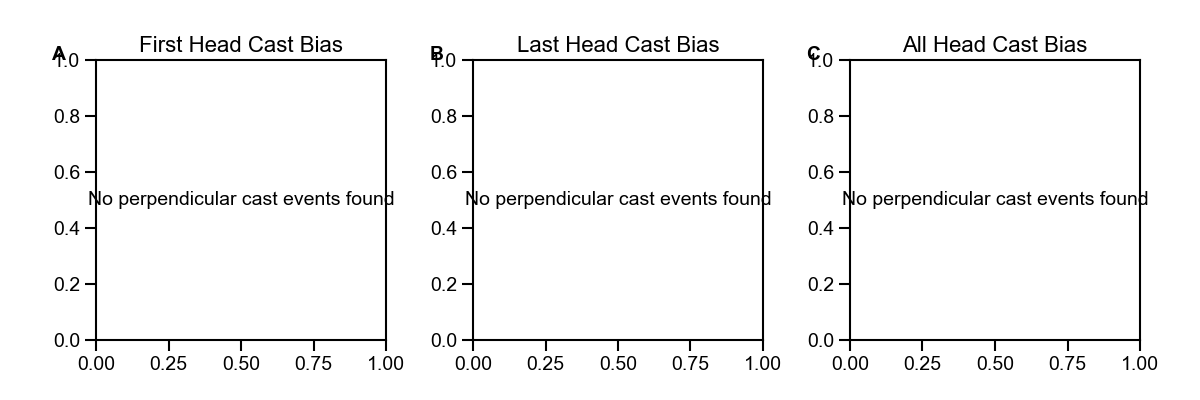

In [47]:
# Create 1x3 figure layout for all three bias analyses
fig_bias = plt.figure(figsize=(12, 4))
gs_bias = GridSpec(1, 3, figure=fig_bias, 
                   left=0.08, right=0.95,
                   top=0.85, bottom=0.15,
                   wspace=0.3)

# Plot first head cast bias
ax_bias1 = fig_bias.add_subplot(gs_bias[0, 0])
plot_data.plot_head_cast_bias_perpendicular(
    combined_bias_all,
    ax=ax_bias1,
    title='First Head Cast Bias'
)
ax_bias1.text(-0.15, 1.05, 'A', transform=ax_bias1.transAxes, 
              fontsize=14, fontweight='bold', va='top', ha='left')

# Plot last head cast bias
ax_bias2 = fig_bias.add_subplot(gs_bias[0, 1])
plot_data.plot_head_cast_bias_perpendicular(
    combined_bias_last,
    ax=ax_bias2,
    title='Last Head Cast Bias'
)
ax_bias2.text(-0.15, 1.05, 'B', transform=ax_bias2.transAxes, 
              fontsize=14, fontweight='bold', va='top', ha='left')

# Plot all head cast bias
ax_bias3 = fig_bias.add_subplot(gs_bias[0, 2])
plot_data.plot_head_cast_bias_perpendicular(
    combined_bias_all,
    ax=ax_bias3,
    title='All Head Cast Bias'
)
ax_bias3.text(-0.15, 1.05, 'C', transform=ax_bias3.transAxes, 
              fontsize=14, fontweight='bold', va='top', ha='left')

# Save the combined figure
fig_bias.savefig(os.path.join(output_dir, 'head_cast_bias_perpendicular_combined.pdf'), 
                bbox_inches='tight', 
                dpi=300,
                transparent=True,
                facecolor='none')
print(f"Combined head cast bias figure saved to: {os.path.join(output_dir, 'head_cast_bias_perpendicular_combined.pdf')}")

plt.show()

In [ ]:
import json
import numpy as np

def save_figure_metadata(output_dir, figure_name, result_files, additional_info=None):
    """
    Save metadata about the files and parameters used to generate a figure.
    
    Args:
        output_dir: Directory where the figure and metadata are saved
        figure_name: Name of the figure (without extension)
        result_files: List of HDF5 files used to generate the figure
        additional_info: Optional dictionary with additional metadata
    """
    def convert_numpy_types(obj):
        """Convert numpy types to Python native types for JSON serialization."""
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        elif isinstance(obj, dict):
            return {key: convert_numpy_types(value) for key, value in obj.items()}
        elif isinstance(obj, list):
            return [convert_numpy_types(item) for item in obj]
        elif isinstance(obj, tuple):
            return tuple(convert_numpy_types(item) for item in obj)
        else:
            return obj
    
    metadata = {
        'figure_name': figure_name,
        'generated_date': datetime.now().isoformat(),
        'source_files': [],
        'total_larvae': 0,
        'experiment_dates': [],
        'analysis_info': additional_info or {}
    }
    
    # Extract information from each source file
    for filepath in result_files:
        try:
            results = load_analysis_results(filepath)
            source_metadata = results.get('metadata', {})
            
            # Extract experiment date from path
            path_parts = filepath.split('/')
            experiment_date = 'unknown'
            for part in path_parts:
                if len(part) == 15 and part.startswith('202'):  # Format: 20240226_145653
                    experiment_date = part
                    break
            
            file_info = {
                'filepath': filepath,
                'original_trx_file': source_metadata.get('source_file', 'unknown'),
                'analysis_date': source_metadata.get('created_date', 'unknown'),
                'n_larvae': int(source_metadata.get('n_larvae_total', 0)),  # Convert to int
                'experiment_date': experiment_date
            }
            
            metadata['source_files'].append(file_info)
            metadata['total_larvae'] += file_info['n_larvae']
            
            if experiment_date not in metadata['experiment_dates']:
                metadata['experiment_dates'].append(experiment_date)
                
        except Exception as e:
            print(f"⚠️  Could not extract metadata from {filepath}: {e}")
    
    # Sort experiment dates
    metadata['experiment_dates'].sort()
    
    # Add summary statistics
    metadata['summary'] = {
        'n_source_files': len(result_files),
        'n_experiments': len(metadata['experiment_dates']),
        'total_larvae': metadata['total_larvae'],
        'date_range': f"{metadata['experiment_dates'][0]} to {metadata['experiment_dates'][-1]}" if metadata['experiment_dates'] else "unknown"
    }
    
    # Convert all numpy types to Python types
    metadata = convert_numpy_types(metadata)
    
    # Save metadata as JSON
    metadata_filepath = os.path.join(output_dir, f'{figure_name}_metadata.json')
    with open(metadata_filepath, 'w') as f:
        json.dump(metadata, f, indent=2)
    
    print(f"📋 Metadata saved to: {metadata_filepath}")
    return metadata_filepath

# Save metadata for the main behavioral analysis figure
behavioral_metadata = save_figure_metadata(
    output_dir, 
    'behavioral_analysis_summary',
    result_files,
    additional_info={
        'analysis_types': ['run_probability', 'turn_probability', 'backup_probability'],
        'plot_types': ['linear_orientation', 'polar_orientation', 'time_series'],
        'parameters': {
            'run_prob_ylim': [0, 0.5],  # Convert tuple to list
            'turn_prob_ylim': [0, 0.4],
            'backup_prob_ylim': [0, 0.1]
        },
        'figure_layout': '3x3 grid',
        'genotype': 'FCF_attP2-40@UAS_TNT_2_0003',
        'condition': 'p_5gradient2_2s1x600s0s#n#n#n'
    }
)

# Save metadata for the velocity & amplitude analysis figure  
velocity_metadata = save_figure_metadata(
    output_dir,
    'velocity_amplitude_analysis', 
    result_files,
    additional_info={
        'analysis_types': ['run_velocity', 'turn_amplitude'],
        'plot_types': ['linear_orientation', 'polar_orientation', 'time_series'],
        'parameters': {
            'min_turn_amplitude': 60,
            'velocity_units': 'body_lengths_per_second',
            'amplitude_units': 'degrees'
        },
        'figure_layout': '2x3 grid',
        'genotype': 'FCF_attP2-40@UAS_TNT_2_0003',
        'condition': 'p_5gradient2_2s1x600s0s#n#n#n'
    }
)

📋 Metadata saved to: /Users/sharbat/Projects/anemotaxis/data/FCF_attP2-40@UAS_TNT_2_0003/p_5gradient2_2s1x600s0s#n#n#n/analyses/behavioral_analysis_summary_metadata.json
📋 Metadata saved to: /Users/sharbat/Projects/anemotaxis/data/FCF_attP2-40@UAS_TNT_2_0003/p_5gradient2_2s1x600s0s#n#n#n/analyses/velocity_amplitude_analysis_metadata.json
